Bu Ã§alÄ±ÅŸma Tez Ã§alÄ±ÅŸmanda deneyini yaptÄ±ÄŸÄ±m bir kaÃ§ senaryodan bir tanesidir.

Ã‡alÄ±ÅŸmada - Savasy tarafÄ±ndan daha Ã¶nce build edilen duygu sÄ±nÄ±flandÄ±rÄ±cÄ±sÄ± modelinin Ã¶ÄŸrenme aÄŸÄ±rlÄ±klarÄ± davranÄ±ÅŸ deÄŸiÅŸimi verisi ile gÃ¼ncellenerek Transfer Learning uygulanmÄ±ÅŸtÄ±r.

AyrÄ±ca bu Ã§alÄ±ÅŸmayÄ± Ã¶zgÃ¼n kÄ±lan bir diÄŸer yaklaÅŸÄ±m ise, tamamÄ± Ä°ngilizce olan verilerden TÃ¼rkÃ§e iÃ§in de anlamlÄ± Ã§alÄ±ÅŸmalar yapÄ±labilmesi iÃ§in Ã¶nce tÃ¼m Ä°ngilizce verinin TÃœrkÃ§eye Ã§evrilmesi ve daha sonra verideki dengesizliklerin giderilmesi iÃ§in back translation yÃ¶ntemi ile veri arttÄ±rÄ±lmasÄ±dÄ±r.



---

This study is one of the few scenarios I have experimented with in my thesis.

In the study - Transfer Learning was applied by updating the learning weights of the emotion classifier model previously built by Savasy with the behavioral change data.

Another approach that makes this study unique is that, in order to be able to conduct meaningful studies for Turkish from the data that is completely English, first all the English data is translated into Turkish and then the data is augmented with the back translation method to eliminate the imbalances in the data.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 21 11:59:01 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/model/verisetleri/balanced_train_dataset.xlsx')
val_data = pd.read_excel('/content/drive/MyDrive/model/verisetleri/val_dataset.xlsx')
test_data = pd.read_excel('/content/drive/MyDrive/model/verisetleri/test_dataset.xlsx')

In [ ]:
train_data.head()

text    label
0      evet. [SEP] onlara Ã¶deme yapmanÄ±n bir yolu ve   change
1  mmhmm. yani yardÄ±mcÄ± oldu [SEP] evet. kendimi ...  sustain
2  ve aynÄ± zamanda, geÃ§miÅŸi bÄ±rakmak zor, ama Ã¶te...   change
3  tamam. [SEP] evet. sanÄ±rÄ±m bunu yapabilirim. ÅŸ...   change
4  ÅŸey, ve biliyorum ki bazÄ± mÃ¼ÅŸteriler Ã¶zgÃ¼rlÃ¼kl...   change

In [ ]:
val_data.head()

text    label
0     evet. [SEP] o ragbi ve kriket aslÄ±nda aynÄ±ydÄ±.  neutral
1  ve bÃ¶ylece, bunu yapmamak sizin iÃ§in daha kola...  neutral
2  hayÄ±r, hayÄ±r. bu kolay olacak. peki senin iÃ§in...   change
3  ve bu biraz korkutucu. [SEP] aman tanrÄ±m, evet...  neutral
4  ve ayrÄ±ca iÃ§tiÄŸinizde bazen bazÄ± ÅŸeyleri unutt...  neutral

In [ ]:
test_data.head()

text    label
0                             hÄ±hÄ±, hÄ±hÄ±. [SEP] eee.  neutral
1  tamam. peki senin iÃ§in nasÄ±l bir ÅŸey? [SEP] be...  neutral
2  Ã¶yleyse, yanÄ±na gidip, hey, mcdonalds patates ...  neutral
3     evet. [SEP] iÅŸte ben de bunu yapmak istiyorum.   change
4                   evet. [SEP] tamam, anladÄ±n iÅŸte.  neutral

In [ ]:
train_data.shape, val_data.shape, test_data.shape

((5214, 2), (706, 2), (706, 2))

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Ã–nceden eÄŸitilmiÅŸ duygu analizi modelini yÃ¼kleyin
model_name = "savasy/bert-base-turkish-sentiment-cased"  # Duygu analizi modeli
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=3,
                                                           ignore_mismatched_sizes=True)

# SÄ±nÄ±f etiketlerini Ã¶zelleÅŸtirin
model.config.id2label = {0: "change", 1: "sustain", 2: "neutral"}
model.config.label2id = {"change": 0, "sustain": 1, "neutral": 2}

# Dropout oranlarÄ±nÄ± ayarlayÄ±n
model.config.hidden_dropout_prob = 0.2  # VarsayÄ±lan 0.1'dir, bunu artÄ±rÄ±yoruz
model.config.attention_probs_dropout_prob = 0.2  # VarsayÄ±lan 0.1'dir, bunu artÄ±rÄ±yoruz

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at savasy/bert-base-turkish-sentiment-cased and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stre

In [ ]:
'''

# Modelin Ã§Ä±kÄ±ÅŸ sÄ±nÄ±flarÄ±nÄ± 3'e uyarlayÄ±n
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=3,
                                                           ignore_mismatched_sizes=True)

# SÄ±nÄ±f etiketlerini Ã¶zelleÅŸtirin
model.config.id2label = {0: "change", 1: "sustain", 2: "neutral"}
model.config.label2id = {"change": 0, "sustain": 1, "neutral": 2}
'''

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at savasy/bert-base-turkish-sentiment-cased and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
# If you have a GPU, you can try forcing the model to use it (or a specific one) like this:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use your desired GPU if you have multiple.
    model = model.to(device)
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    model = model.to(device)
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
"""# EÄŸitim, doÄŸrulama ve test setlerine ayÄ±rÄ±n
from sklearn.model_selection import train_test_split

train_texts, remaining_texts, train_labels, remaining_labels = train_test_split(
    data_4["terapist_danisan"],
    data_4["label"],
    test_size=0.3,
    random_state=42
)

# Remaining data is further split into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    remaining_texts,
    remaining_labels,
    test_size=0.5,
    random_state=42
)

"""

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset

In [ ]:
# label_mapping sÃ¶zlÃ¼ÄŸÃ¼nÃ¼ tanÄ±mla
label_mapping = {"change": 0, "sustain": 1, "neutral": 2}

# train_data'yÄ± Dataset nesnesine dÃ¶nÃ¼ÅŸtÃ¼r
train_dataset = Dataset.from_pandas(train_data)

# val_data'yÄ± Dataset nesnesine dÃ¶nÃ¼ÅŸtÃ¼r
val_dataset = Dataset.from_pandas(val_data)

# test_data'yÄ± Dataset nesnesine dÃ¶nÃ¼ÅŸtÃ¼r
test_dataset = Dataset.from_pandas(test_data)

# Her bir veri kÃ¼mesindeki 'label' sÃ¼tununu eÅŸle
train_dataset = train_dataset.map(lambda example: {'label': label_mapping[example['label']]})
val_dataset = val_dataset.map(lambda example: {'label': label_mapping[example['label']]})
test_dataset = test_dataset.map(lambda example: {'label': label_mapping[example['label']]})

Map:   0%|          | 0/5214 [00:00<?, ? examples/s]

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

In [ ]:
sample = train_dataset.take(5)
df = sample.to_pandas()
display(df)

text  label
0      evet. [SEP] onlara Ã¶deme yapmanÄ±n bir yolu ve      0
1  mmhmm. yani yardÄ±mcÄ± oldu [SEP] evet. kendimi ...      1
2  ve aynÄ± zamanda, geÃ§miÅŸi bÄ±rakmak zor, ama Ã¶te...      0
3  tamam. [SEP] evet. sanÄ±rÄ±m bunu yapabilirim. ÅŸ...      0
4  ÅŸey, ve biliyorum ki bazÄ± mÃ¼ÅŸteriler Ã¶zgÃ¼rlÃ¼kl...      0

In [ ]:
# Tokenizasyon
def tokenize_function(examples):
    # Make sure input data is padded on the CPU before moving to the GPU
    inputs = tokenizer(examples["text"], padding="longest", truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()} # Now move to GPU after padding
    return inputs

In [ ]:
train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5214 [00:00<?, ? examples/s]

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

In [ ]:
'''from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/model/results_2",
    evaluation_strategy="epoch",  # Changed to "epoch" to match save_strategy
    learning_rate=1e-5,
    save_steps=500,            # Can be kept as is if you want intermediate saves
    eval_steps=500,            # Now redundant but won't cause issues
    per_device_train_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False  # Daha dÃ¼ÅŸÃ¼k kayÄ±p daha iyi
)

'''

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ðŸ¤— Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/model/back_translation_oversampling_duygu_transfer_dinamik_tokenization",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    save_steps=500,            # Can be kept as is if you want intermediate saves
    eval_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=25,
    weight_decay=0.05,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1", #deÄŸiÅŸtirmeyi unutma
    greater_is_better=True, #deÄŸiÅŸtirmeyi unutma
    fp16=True,  # Enable mixed precision training if your GPU supports it
    gradient_accumulation_steps=1,  # Accumulate gradients over multiple steps
    # **Mitigating Algorithmic Bias**
    seed=42, # Set a random seed for reproducibility
    # Consider adding more data augmentation or bias-aware fine-tuning techniques if applicable to your dataset.
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ðŸ¤— Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
!pip install evaluate

In [ ]:
from datasets import load_dataset # This is for loading datasets
from evaluate import load # This is for loading metrics

In [ ]:
#from datasets import load_metric # This line is replaced

# Metrikleri yÃ¼kleyin
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")

# DeÄŸerlendirme fonksiyonunu tanÄ±mlayÄ±n
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    print(f"Logits shape: {logits.shape}") # Print logits shape
    print(f"Labels shape: {labels.shape}") # Print labels shape
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42) # 5 katlÄ± Ã§apraz doÄŸrulama

In [ ]:
best_model_path = "/content/drive/MyDrive/model/back_translation_oversampling_duygu_transfer_dinamik_tokenization/model_back_translation_oversampling_duygu_tf_cv_5_dinamik"  # En iyi modelin kaydedileceÄŸi yol

In [ ]:
from collections import defaultdict
from transformers import EarlyStoppingCallback, TrainingArguments, Trainer


In [ ]:
# from transformers import AdamW

In [ ]:
#optimizer = AdamW(model.parameters(), lr= 1e-5)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
best_epochs = []
fold_metrics = defaultdict(dict)

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold}")
    train_fold = train_dataset.select(train_ids)
    val_fold = train_dataset.select(val_ids)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_fold.map(tokenize_function, batched=True), # train_fold kullanÄ±n
        eval_dataset=val_fold.map(tokenize_function, batched=True),  # val_fold kullanÄ±n
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
        #optimizers=(optimizer, None)

    )

    train_results = trainer.train()
    best_epochs.append(int(train_results.metrics["epoch"]))  # En iyi epoch'u kaydedin (int olarak)

    # Get evaluation metrics (including eval_loss) using evaluate()
    eval_results = trainer.evaluate() # Evaluate to get eval_loss
    metrics = eval_results
    #predictions = trainer.predict(val_fold.map(tokenize_function, batched=True)) # This line is no longer needed.
    #metrics = compute_metrics((predictions.predictions, predictions.label_ids)) # This is also not needed.

    print(f"Fold {fold} metrics: {metrics}")

    for metric_name, metric_value in metrics.items():
        fold_metrics[fold][metric_name] = metric_value

    # En iyi modeli kaydet
    if fold == 0 or metrics["eval_loss"] < best_loss:  # Now you can access eval_loss
        best_loss = metrics["eval_loss"]
        trainer.save_model(best_model_path)
        print(f"En iyi model Fold {fold} iÃ§in kaydedildi.")

print("En iyi model:", best_model_path)
print("Her katÄ±n en iyi epoch'larÄ±:", best_epochs)

metrics_df = pd.DataFrame.from_dict(fold_metrics, orient='index')
print(metrics_df)

Fold 0


Map:   0%|          | 0/4171 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

<ipython-input-26-82b34bb99a99>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: hcanbarutcu (hcanbarutcu-istanbul-university). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)


Logits shape: (1043, 3)
Labels shape: (1043,)
Fold 0 metrics: {'eval_loss': 0.8709537386894226, 'eval_accuracy': 0.8465963566634708, 'eval_precision': 0.8487173073510117, 'eval_recall': 0.8465963566634708, 'eval_f1': 0.8460392331579184, 'eval_runtime': 4.7409, 'eval_samples_per_second': 220.0, 'eval_steps_per_second': 13.921, 'epoch': 16.0}
En iyi model Fold 0 iÃ§in kaydedildi.
Fold 1


Map:   0%|          | 0/4171 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

<ipython-input-26-82b34bb99a99>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)


Logits shape: (1043, 3)
Labels shape: (1043,)
Fold 1 metrics: {'eval_loss': 0.03333102911710739, 'eval_accuracy': 0.9913710450623202, 'eval_precision': 0.9913709081396251, 'eval_recall': 0.9913710450623202, 'eval_f1': 0.991361662606138, 'eval_runtime': 4.7456, 'eval_samples_per_second': 219.783, 'eval_steps_per_second': 13.908, 'epoch': 14.0}
En iyi model Fold 1 iÃ§in kaydedildi.
Fold 2


Map:   0%|          | 0/4171 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

<ipython-input-26-82b34bb99a99>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)


Logits shape: (1043, 3)
Labels shape: (1043,)
Fold 2 metrics: {'eval_loss': 0.025112152099609375, 'eval_accuracy': 0.9932885906040269, 'eval_precision': 0.9933327401815604, 'eval_recall': 0.9932885906040269, 'eval_f1': 0.9932864950950782, 'eval_runtime': 4.3598, 'eval_samples_per_second': 239.229, 'eval_steps_per_second': 15.138, 'epoch': 7.0}
En iyi model Fold 2 iÃ§in kaydedildi.
Fold 3


Map:   0%|          | 0/4171 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

<ipython-input-26-82b34bb99a99>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)


Logits shape: (1043, 3)
Labels shape: (1043,)
Fold 3 metrics: {'eval_loss': 0.0302297230809927, 'eval_accuracy': 0.9913710450623202, 'eval_precision': 0.991389709188127, 'eval_recall': 0.9913710450623202, 'eval_f1': 0.9913741754577946, 'eval_runtime': 4.4752, 'eval_samples_per_second': 233.063, 'eval_steps_per_second': 14.748, 'epoch': 8.0}
Fold 4


Map:   0%|          | 0/4172 [00:00<?, ? examples/s]

Map:   0%|          | 0/1042 [00:00<?, ? examples/s]

<ipython-input-26-82b34bb99a99>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)


Logits shape: (1042, 3)
Labels shape: (1042,)
Fold 4 metrics: {'eval_loss': 0.024992551654577255, 'eval_accuracy': 0.9942418426103646, 'eval_precision': 0.9942834162347285, 'eval_recall': 0.9942418426103646, 'eval_f1': 0.9942460242213019, 'eval_runtime': 4.442, 'eval_samples_per_second': 234.579, 'eval_steps_per_second': 14.858, 'epoch': 9.0}
En iyi model Fold 4 iÃ§in kaydedildi.
En iyi model: /content/drive/MyDrive/model/back_translation_oversampling_duygu_transfer_dinamik_tokenization/model_back_translation_oversampling_duygu_tf_cv_5_dinamik
Her katÄ±n en iyi epoch'larÄ±: [16, 14, 7, 8, 9]
   eval_loss  eval_accuracy  eval_precision  eval_recall   eval_f1  \
0   0.870954       0.846596        0.848717     0.846596  0.846039   
1   0.033331       0.991371        0.991371     0.991371  0.991362   
2   0.025112       0.993289        0.993333     0.993289  0.993286   
3   0.030230       0.991371        0.991390     0.991371  0.991374   
4   0.024993       0.994242        0.994283     0.9

In [ ]:
'''
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized, # Add this line to provide the evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

'''

<ipython-input-19-b3ae9fb9b5db>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
'''
# Modeli eÄŸit
trainer.train()
'''

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 Â·Â·Â·Â·Â·Â·Â·Â·Â·Â·


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels sh

TrainOutput(global_step=11050, training_loss=0.0887444714615248, metrics={'train_runtime': 2487.7326, 'train_samples_per_second': 70.908, 'train_steps_per_second': 4.442, 'total_flos': 2.374884730836979e+16, 'train_loss': 0.0887444714615248, 'epoch': 50.0})

In [ ]:
'''
metrics = trainer.evaluate()
print(metrics)

'''

Logits shape: (588, 3)
Labels shape: (588,)
{'eval_loss': 0.6817567944526672, 'eval_accuracy': 0.7312925170068028, 'eval_precision': 0.7188202143360436, 'eval_recall': 0.7312925170068028, 'eval_f1': 0.7184830856242643, 'eval_runtime': 2.4945, 'eval_samples_per_second': 235.721, 'eval_steps_per_second': 29.666, 'epoch': 50.0}


In [ ]:
# Tahminleri al
predictions = trainer.predict(test_tokenized) # Use the tokenized test dataset

# Logits (modelin Ã§Ä±ktÄ±larÄ±) ve gerÃ§ek etiketler
logits = predictions.predictions
true_labels = predictions.label_ids

# Tahmin edilen sÄ±nÄ±flar
import numpy as np
predicted_labels = np.argmax(logits, axis=1)

Logits shape: (706, 3)
Labels shape: (706,)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {round(accuracy,4)}")
print(f"Precision: {round(precision,4)}")
print(f"Recall: {round(recall,4)}")
print(f"F1 Score: {round(f1,4)}")

Accuracy: 0.6289
Precision: 0.6685
Recall: 0.6289
F1 Score: 0.6391


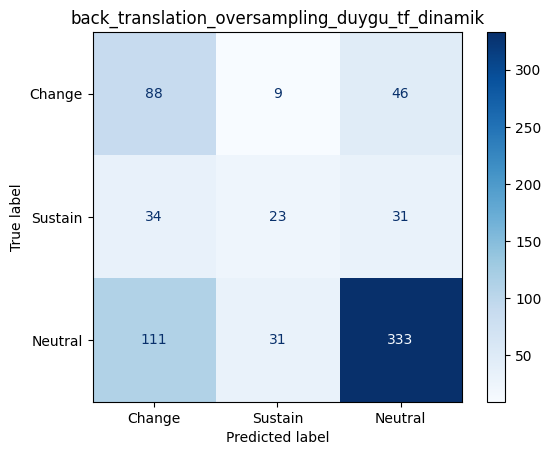

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Grafik oluÅŸtur
fig, ax = plt.subplots()

# Confusion matrix baÅŸlÄ±ÄŸÄ±
ax.set_title("back_translation_oversampling_duygu_tf_dinamik")

# KarÄ±ÅŸÄ±klÄ±k matrisini oluÅŸtur ve Ã§izdir
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Change", "Sustain", "Neutral"])
disp.plot(cmap="Blues", ax=ax)  # ax parametresi ile mevcut grafiÄŸi belirt


[[61.54  6.29 32.17]
 [38.64 26.14 35.23]
 [23.37  6.53 70.11]]


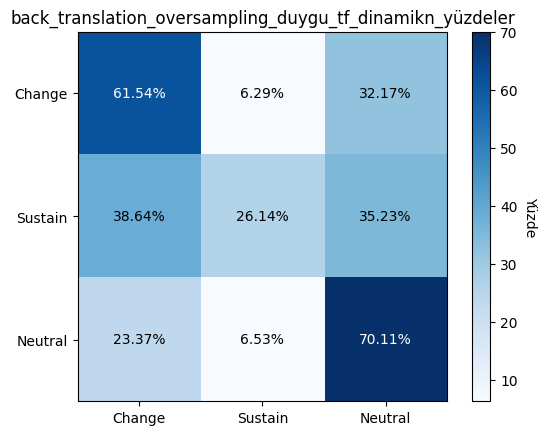

In [ ]:
# Her etiket iÃ§in yÃ¼zdeleri hesapla
row_sums = conf_matrix.sum(axis=1, keepdims=True)  # Her satÄ±rÄ±n toplamÄ±nÄ± hesapla
conf_matrix_percent = np.round(conf_matrix / row_sums * 100, 2)  # YÃ¼zdeleri elde etmek iÃ§in bÃ¶l


# SonuÃ§larÄ± yazdÄ±r
print(conf_matrix_percent)


# Grafik oluÅŸtur
fig, ax = plt.subplots()

# Heatmap oluÅŸtur
im = ax.imshow(conf_matrix_percent, cmap="Blues")

# Eksen etiketleri
ax.set_xticks(np.arange(conf_matrix_percent.shape[1]))
ax.set_yticks(np.arange(conf_matrix_percent.shape[0]))
ax.set_xticklabels(["Change", "Sustain", "Neutral"])
ax.set_yticklabels(["Change", "Sustain", "Neutral"])

# HÃ¼cre deÄŸerlerini gÃ¶ster
for i in range(conf_matrix_percent.shape[0]):
    for j in range(conf_matrix_percent.shape[1]):
        text = ax.text(j, i, f"{conf_matrix_percent[i, j]}%",
                       ha="center", va="center", color="white" if conf_matrix_percent[i, j] > 50 else "black")

# Renk Ã§ubuÄŸu
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("YÃ¼zde", rotation=-90, va="bottom")

# BaÅŸlÄ±k
ax.set_title("back_translation_oversampling_duygu_tf_dinamikn_yÃ¼zdeler")

plt.show()

In [ ]:
metrics_df

eval_loss  eval_accuracy  eval_precision  eval_recall   eval_f1  \
0   0.870954       0.846596        0.848717     0.846596  0.846039   
1   0.033331       0.991371        0.991371     0.991371  0.991362   
2   0.025112       0.993289        0.993333     0.993289  0.993286   
3   0.030230       0.991371        0.991390     0.991371  0.991374   
4   0.024993       0.994242        0.994283     0.994242  0.994246   

   eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  
0        4.7409                  220.000                 13.921   16.0  
1        4.7456                  219.783                 13.908   14.0  
2        4.3598                  239.229                 15.138    7.0  
3        4.4752                  233.063                 14.748    8.0  
4        4.4420                  234.579                 14.858    9.0

In [ ]:
test_res = pd.DataFrame([[accuracy, precision, recall, f1]],
                        columns=['accuracy', 'precision', 'recall', 'f1'])
test_res

accuracy  precision    recall        f1
0  0.628895   0.668454  0.628895  0.639096

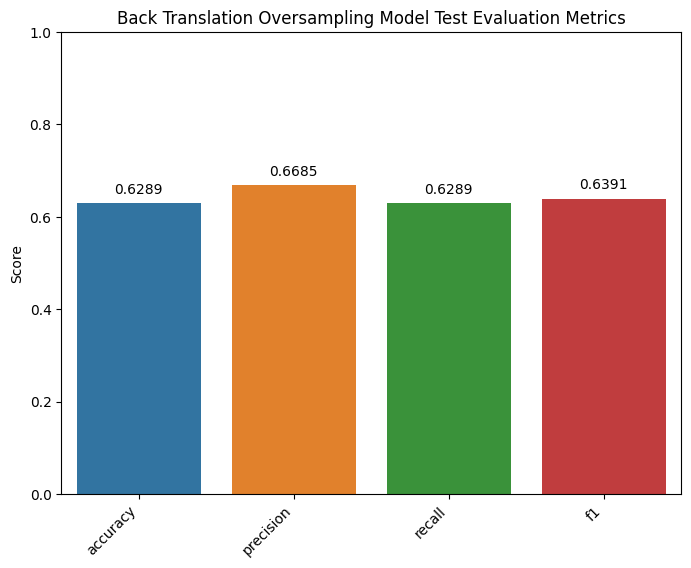

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=test_res)  # Store the Axes object returned by sns.barplot
plt.title("Back Translation Oversampling Model Test Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")

# Add values on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()